In [1]:
# 1. Install Dependencies
!pip install torch torchvision matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from google.colab import files
uploaded = files.upload()


Saving cifar-10-python.tar.gz to cifar-10-python.tar.gz


In [3]:
import tarfile
tar = tarfile.open("cifar-10-python.tar.gz", "r:gz")
tar.extractall()
tar.close()


In [4]:
import pickle
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load a single CIFAR-10 batch
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data'].reshape(10000, 3, 32, 32).astype("float32")
        Y = np.array(datadict[b'labels'])
        return X, Y

In [6]:
# Load all data
def load_cifar10(path):
    xs, ys = [], []
    for i in range(1, 6):
        f = os.path.join(path, f'data_batch_{i}')
        X, Y = load_cifar_batch(f)
        xs.append(X)
        ys.append(Y)
    X_train = np.concatenate(xs)
    Y_train = np.concatenate(ys)
    X_test, Y_test = load_cifar_batch(os.path.join(path, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

X_train, y_train, X_test, y_test = load_cifar10("cifar-10-batches-py")

In [7]:
# Normalize and convert to torch tensors
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

X_train = torch.tensor(X_train / 255.0, dtype=torch.float32)
X_test = torch.tensor(X_test / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [8]:
# Dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
# Define CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)


In [10]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(5):
    running_loss = 0.0
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}")

Epoch 1, Loss: 1104.979
Epoch 2, Loss: 796.269
Epoch 3, Loss: 657.276
Epoch 4, Loss: 553.327
Epoch 5, Loss: 450.419


In [11]:
# Evaluate the model
net.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1000
           1       0.81      0.84      0.82      1000
           2       0.61      0.66      0.63      1000
           3       0.52      0.55      0.54      1000
           4       0.69      0.62      0.65      1000
           5       0.62      0.61      0.62      1000
           6       0.88      0.72      0.79      1000
           7       0.71      0.84      0.77      1000
           8       0.86      0.76      0.81      1000
           9       0.76      0.81      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



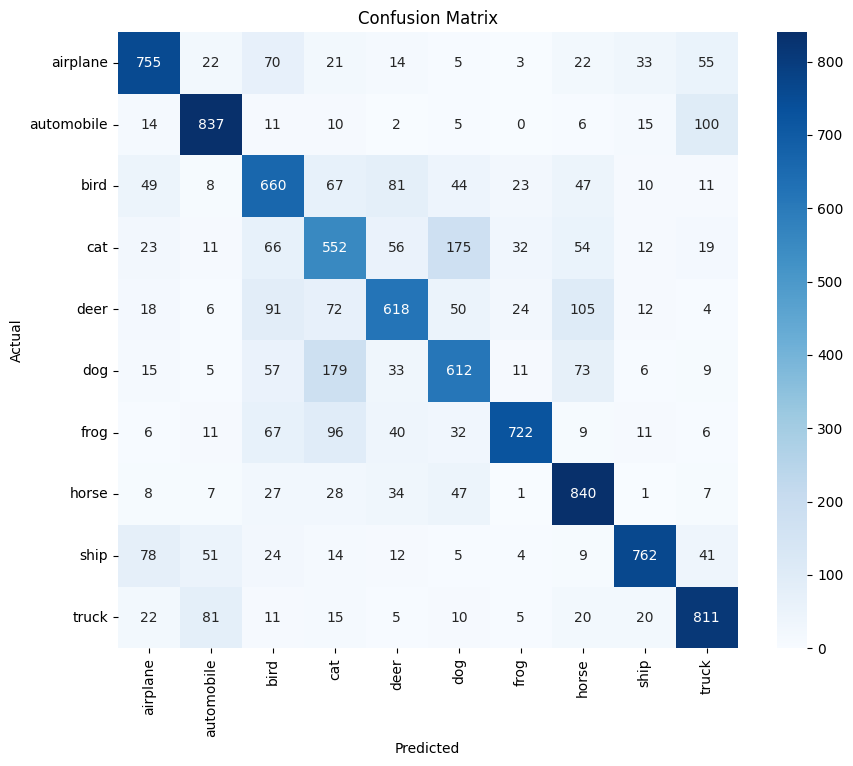

In [12]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()


In [13]:
# Save model
torch.save(net.state_dict(), "cifar10_model.pth")
